# Path-integral Monte Carlo for the 1d harmonic oscillator
Jan Gukelberger, Andreas Hehn, Georg Winkler (2011-2016)

In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from sys import stdout
%matplotlib inline
plt.rcParams['figure.figsize'] = 16, 9

### Some definitions

In [2]:
# hbar = m = 1
w = 1.0

# seed random number generator once at program start
rnd.seed(42)

### Class for storing world-line configuration and doing updates/measurements

In [3]:
class Config:
    """PIMC configuration: world-line for one particle"""
    def __init__(self,beta,slices):
        self.beta_ = float(beta)
        self.slices_ = float(slices)
        self.tau_ = self.beta_/self.slices_
        self.config_ = rnd.uniform(-1.,1.,slices)
        
    def potential_energy(self):
        """Return the potential energy of a configuration X"""
        energy = 0.0
        for i in self.config_:
            energy += i**2
        energy /= self.slices_
        return 0.5*(w**2)*energy

    def kinetic_energy(self):
        """Return the kinetic energy of a configuration X"""
        mean_r_prime_square = 0.0;
        for i in range(self.config_.size):
            mean_r_prime_square += (self.config_[i]-self.config_[i-1])**2
        mean_r_prime_square /= self.slices_
        return 1/(2.*self.tau_) - 0.5*mean_r_prime_square/self.tau_**2
    
    def position_histogram(self, bins, value_range):
        """Return histogram of positions in all time slices"""
        return np.histogram(self.config_,bins,range=value_range)[0]

    def update(self,max_displacement):
        """Metropolis algorithm local configuration update"""
        # pick a random time slice and propose a new position
        j = rnd.randint(0,self.config_.size)
        new_position_j = rnd.uniform(-max_displacement,max_displacement) + self.config_[j]

        # periodic boundary conditions:
        jp1 = (j + 1)%self.config_.size

        # see script section 7.1.4
        chi = np.exp(
                - ( (self.config_[j-1] - new_position_j)**2 + ( new_position_j - self.config_[jp1])**2
                    - ( (self.config_[j-1] - self.config_[j])**2 + (self.config_[j] - self.config_[jp1])**2 )
                  )/(2.0*self.tau_)
                - self.tau_*0.5*w**2*(new_position_j**2-self.config_[j]**2)
              )
              
        if chi >= 1 or rnd.uniform() < chi:
            self.config_[j] = new_position_j
            return True
        else:
            return False
        
    def sweep(self,max_displacement):
        """One sweep of Metropolis local updates (i.e. self.slices_ update proposals)"""
        accepted_proposals = 0
        for l in range(self.config_.size):
            accepted_proposals += self.update(max_displacement)
        return accepted_proposals/self.slices_

### Binning analysis for error

In [4]:
def binning_analysis(samples):
    """Perform a binning analysis over samples and return an array of the error estimate at each binning level."""
    minbins = 2**7 # minimum number of bins (128 still seems to be a reasonable sample size in most cases)
    maxlevel = int(np.log2(len(samples)//minbins))
    maxsamples = minbins * 2**(maxlevel)
    bins = np.array(samples[-maxsamples:]) # clip to power of 2 for simplicity
    errors = np.zeros(maxlevel+1)
    for k in range(maxlevel+1):
        errors[k] = np.std(bins)/np.sqrt(len(bins)-1.)
        bins = np.array([(bins[2*i]+bins[2*i+1])/2. for i in range(len(bins)//2)])
    return errors

### Do simulation

In [5]:
# simulation parameters
beta = 10.
M = int(10*beta)
steps = 2**21 #2**18
#thermal_steps = steps//8
thermal_steps = 500000
max_displacement = .5
# parameters for wave function measurements (x histogram)
histo_range = (-4.0,4.0)
histo_bins = 100
histo_samples = 64

# initialize configuration and observables
c = Config(beta,M)
potential_energy    = np.empty(steps,dtype=float)
kinetic_energy      = np.empty(steps,dtype=float)
position_histogram  = np.zeros((histo_samples,histo_bins))
acc_rate = 0.

# thermalize configuration
print('Thermalization ('+str(thermal_steps)+' sweeps)...')
for i in range(thermal_steps):
    c.sweep(max_displacement)

# simulation: measures after each update sweep
print('Simulation ('+str(steps)+' sweeps)')
for i in range(steps):
    acc_rate += c.sweep(max_displacement)

    # Measurements
    potential_energy[i] = c.potential_energy()
    kinetic_energy[i]   = c.kinetic_energy()
    position_histogram[i*histo_samples//steps] += c.position_histogram(histo_bins,histo_range)

    # Progress marker: one . for each percent
    if i % (steps//100) == 0:
        stdout.write('.')
        stdout.flush()

# If the acceptance rate is not somewhere around 0.5, max_displacement needs to be tuned.
acc_rate /= steps
print('\nAcceptance rate = '+str(acc_rate))

Thermalization (500000 sweeps)...
Simulation (2097152 sweeps)
.....................................................................................................
Acceptance rate = 0.5943481349985842


### Measure Observables

In [6]:
# Evaluate results
pot = np.mean(potential_energy)
kin = np.mean(kinetic_energy)
# naive error estimate
pot_error_naive = np.std(potential_energy)/np.sqrt(steps-1.)
kin_error_naive = np.std(kinetic_energy)/np.sqrt(steps-1)
# running mean
pot_series = np.cumsum(potential_energy)/np.arange(1,steps+1)
kin_series = np.cumsum(kinetic_energy)/np.arange(1,steps+1)
# binning analysis
pot_binning = binning_analysis(potential_energy)
kin_binning = binning_analysis(kinetic_energy)
pot_error = pot_binning[-1]
kin_error = kin_binning[-1]
pot_tau = .5*(pot_error**2/pot_error_naive**2 - 1.)
kin_tau = .5*(kin_error**2/kin_error_naive**2 - 1.)
print('+++ Naive estimates:')
print("Potential Energy = " + str(pot) + " +/- " + str(pot_error_naive))
print("Kinetic Energy   = " + str(kin) + " +/- " + str(kin_error_naive))
print('+++ Binning analysis:')
print("Potential Energy = " + str(pot) + " +/- " + str(pot_error) + "\tCorrelation time: " + str(pot_tau))
print("Kinetic Energy   = " + str(kin) + " +/- " + str(kin_error) + "\tCorrelation time: " + str(kin_tau))
# The following error estimate ignores cross-correlations between T and V.
# Do you have an idea how to fix that?
print("Total Energy     = " + str(pot+kin) + " +/- " + str(pot_error+kin_error))
print('Exact result   E = ' + str(.5*w/np.tanh(.5*w*beta)))

+++ Naive estimates:
Potential Energy = 0.247399361174 +/- 7.49110854274e-05
Kinetic Energy   = 0.25091824535 +/- 0.000469708232395
+++ Binning analysis:
Potential Energy = 0.247399361174 +/- 0.00161825856465	Correlation time: 232.83165048
Kinetic Energy   = 0.25091824535 +/- 0.00172176760235	Correlation time: 6.2183515248
Total Energy     = 0.498317606525 +/- 0.003340026167
Exact result   E = 0.500045401991


### Some figures

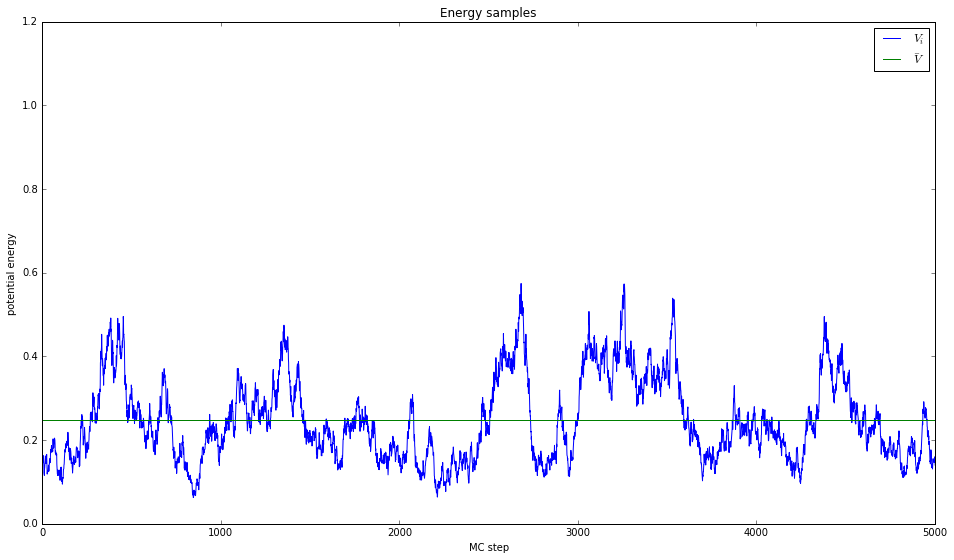

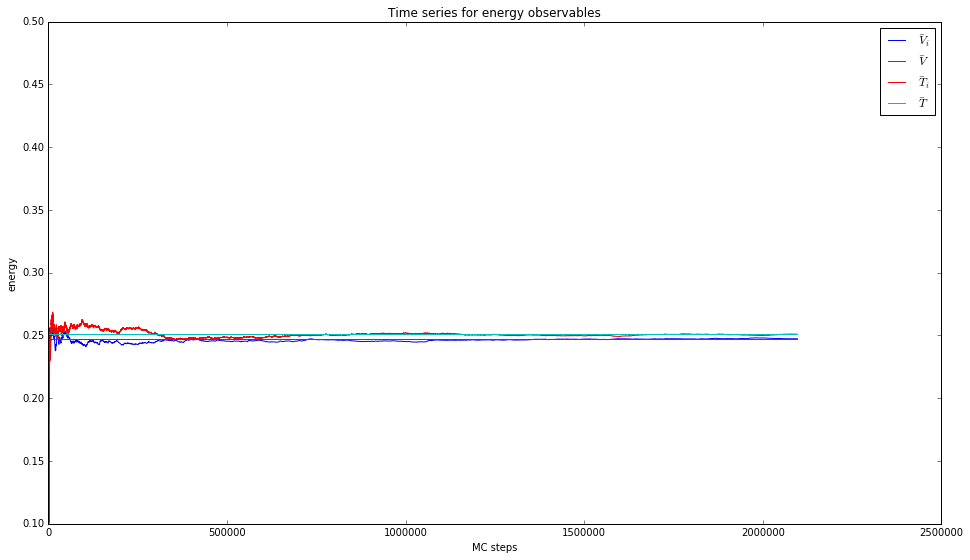

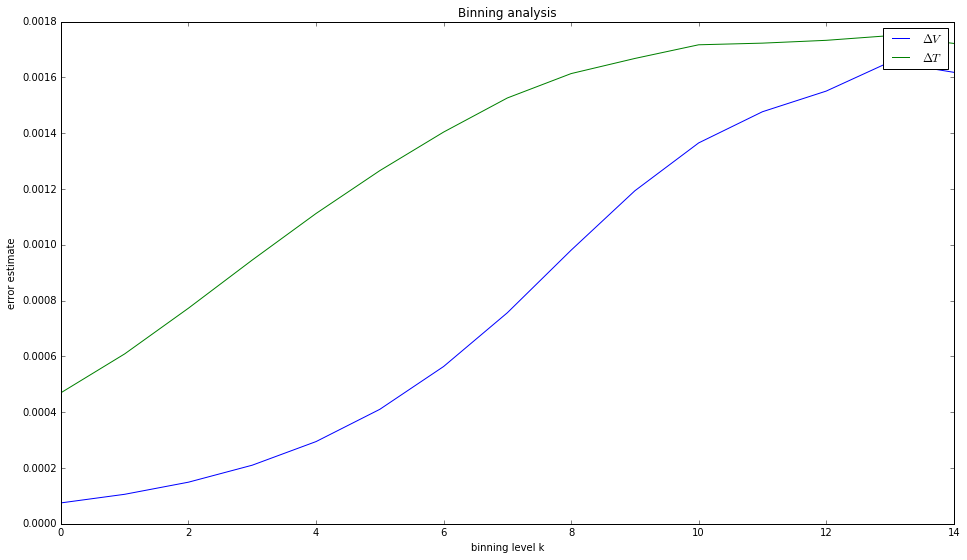

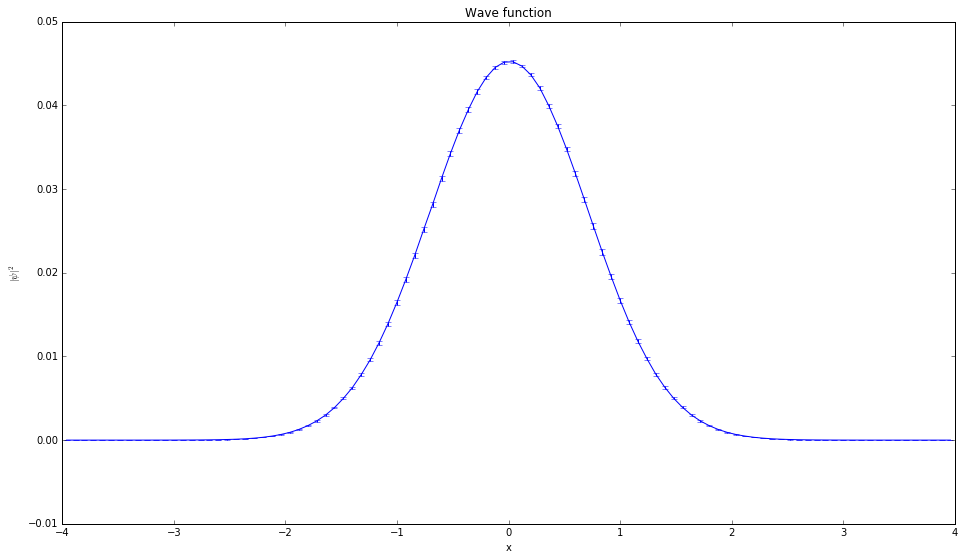

In [7]:
# Plot raw samples
plt.figure()
plt.title('Energy samples')
plt.xlabel('MC step')
plt.ylabel('potential energy')
plt.plot(range(steps),potential_energy,label='$V_i$')
plt.plot([0,steps-1],[pot,pot],label='$\\bar{V}$')
#plt.plot(range(steps),kinetic_energy,label='$T_i$')
#plt.plot([0,steps-1],[kin,kin],label='$\\bar{T}$')
plt.xlim([0,5000])
plt.legend()

# Plot running mean
plt.figure()
plt.title('Time series for energy observables')
plt.xlabel('MC steps')
plt.ylabel('energy')
plt.plot(range(steps),pot_series,label='$\\bar{V}_i$')
plt.plot([0,steps-1],[pot,pot],label='$\\bar{V}$')
plt.plot(range(steps),kin_series,label='$\\bar{T}_i$')
plt.plot([0,steps-1],[kin,kin],label='$\\bar{T}$')
plt.ylim([0.1,0.5])
plt.legend()

# Plot binning analysis
plt.figure()
plt.title('Binning analysis')
plt.xlabel('binning level k')
plt.ylabel('error estimate')
plt.plot(pot_binning,label='$\\Delta V$')
plt.plot(kin_binning,label='$\\Delta T$')
plt.legend()

# Normalize histogram and calculate error bars: 
# We did not collect a complete time series, but a fixed number of bins. 
# This works as long as the size of each bin [steps/histo_samples] >> [autocorrelation time]
position_histogram /= np.sum(position_histogram,axis=1).reshape((histo_samples,1))
histomean = np.mean(position_histogram,axis=0)
histoerr = np.std(position_histogram,axis=0)/np.sqrt(histo_samples-1)

# Plot wave function
plt.figure()
plt.title('Wave function')
plt.xlabel('x')
plt.ylabel("$|\\psi|^2$")
binwidth = (histo_range[1]-histo_range[0])/histo_bins
plt.errorbar(np.linspace(histo_range[0]+binwidth/2,histo_range[1]-binwidth/2,histo_bins),histomean,histoerr)
plt.show()